# 4. Modeling - Random Forest
---

### Library and Data Import

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns

import pickle

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
all_seasons = pd.read_csv('../data/batters_all_seasons_custom.csv')

### Train Test Split / Scaling

In [4]:
X = all_seasons.drop(columns=['Name', 'Tm', 'G',
                              'playerId', 'CS', 'SB',
                              'next_game_hit'])
y = all_seasons['next_game_hit']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [6]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/Users/BK/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/BK/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/BK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### Instantiating & Fitting the Model

In [27]:
rf = RandomForestClassifier(random_state=51)
rf_params = {
    'n_estimators': [50, 100, 125, 150, 175],
    'max_depth': [6, 7, 9, 11],
    'max_features': [5, 6, 8, 10],
    'min_samples_split': [2, 5, 9, 11, 13]
}

In [28]:
# gs = GridSearchCV(rf, param_grid=rf_params, n_jobs=-1, cv=5)
# gs.fit(X_train_sc, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=51, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 125, 150, 175], 'max_depth': [6, 7, 9, 11], 'max_features': [5, 6, 8, 10], 'min_samples_split': [2, 5, 9, 11, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
# with open('../models/gridsearch3.pkl', 'wb') as f:
#     pickle.dump(gs, f)

### Model Evaluation

In [ ]:
# with open('../models/gridsearch3.pkl', 'rb') as f:
#     gs = pickle.load(f)

In [30]:
gs.best_params_

{'max_depth': 6,
 'max_features': 10,
 'min_samples_split': 2,
 'n_estimators': 175}

In [31]:
gs.score(X_train_sc, y_train)

0.6193118305794362

In [32]:
gs.score(X_test_sc, y_test)

0.6077678190354247

In [33]:
rf_preds = gs.predict(X_test_sc)

In [15]:
def score_model(actuals, predictions):
    tn, fp, fn, tp = confusion_matrix(actuals, predictions).ravel()
    print(f'T Pos: {tp},   F Pos: {fp}')
    print(f'F Neg: {fn},   T Neg: {tn}')
    print(f'Accuracy: {(tp+tn)/len(predictions)}')
    print(f'Precision: {tp/(tp+fp)}')

In [34]:
score_model(y_test, rf_preds)

T Pos: 17855,   F Pos: 11348
F Neg: 1518,   T Neg: 2081
Accuracy: 0.6077678190354247
Precision: 0.6114097866657535


In [35]:
rf_pred_proba = [i[1] for i in gs.predict_proba(X_test_sc)]

rf_pred_df = pd.DataFrame({'true_values': y_test,
                           'pred_probs':rf_pred_proba})

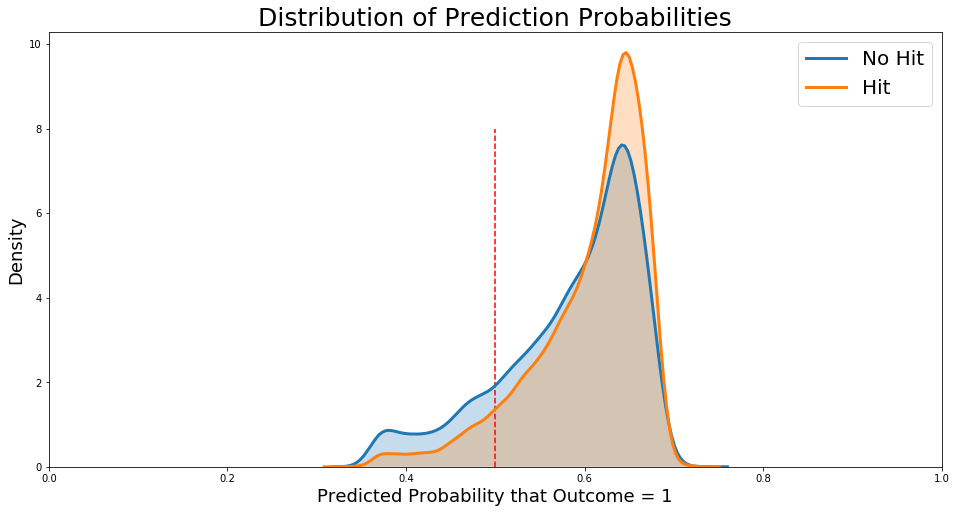

In [36]:
plt.figure(figsize = (16,8))

plt.vlines(x=0.5,
           ymin = 0,
           ymax = 8,
           color='r',
           linestyle = '--')

sns.distplot(rf_pred_df[rf_pred_df['true_values'] == 0]['pred_probs'],
             hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3},
             label='No Hit')
sns.distplot(rf_pred_df[rf_pred_df['true_values'] == 1]['pred_probs'],
             hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3},
             label='Hit')



plt.title('Distribution of Prediction Probabilities', fontsize=25)
plt.ylabel('Density', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.xlim(0,1)

plt.legend(fontsize=20);

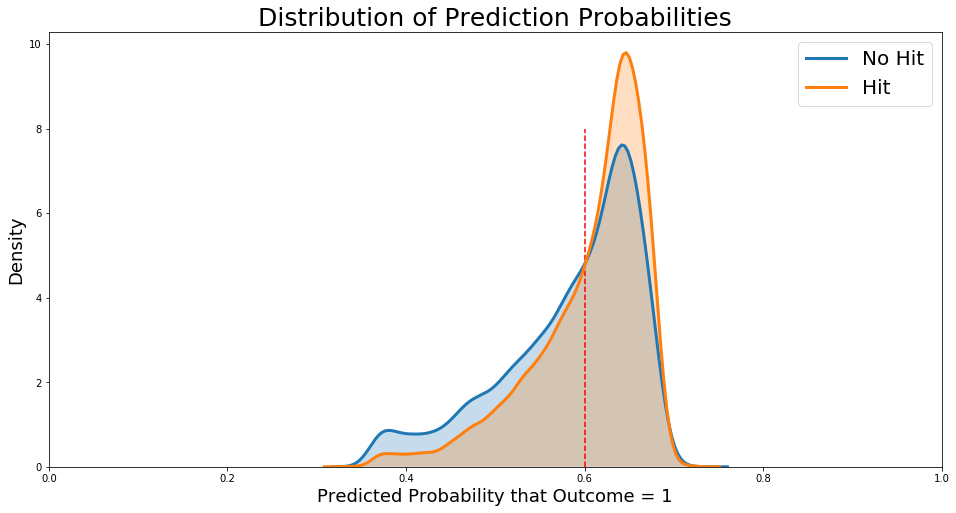

In [37]:
plt.figure(figsize = (16,8))

plt.vlines(x=0.6,
           ymin = 0,
           ymax = 8,
           color='r',
           linestyle = '--')

sns.distplot(rf_pred_df[rf_pred_df['true_values'] == 0]['pred_probs'],
             hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3},
             label='No Hit')
sns.distplot(rf_pred_df[rf_pred_df['true_values'] == 1]['pred_probs'],
             hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3},
             label='Hit')



plt.title('Distribution of Prediction Probabilities', fontsize=25)
plt.ylabel('Density', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.xlim(0,1)

plt.legend(fontsize=20);

In [38]:
rf_preds60 = (gs.predict_proba(X_test_sc)[:,1] >= 0.6).astype(bool)

In [39]:
score_model(y_test, rf_preds60)

T Pos: 12565,   F Pos: 7095
F Neg: 6808,   T Neg: 6334
Accuracy: 0.5761538930553015
Precision: 0.6391149542217701


---
## Conclusion

The random forest model has not succeeded in improving over the logistic regression model's performance. Because this method is more computationally intensive and harder to interpret on top of the diminished performance, I will move on to another modeling method.